In the previous example, the max-cut problem was solved using QAOA. Solving the max-cut problem is effectively a binary classifier. In this notebook, we focus on techniques that allow a binary classifier to cluster data into 2+ groups. To summarize this idea with a single question: How can a binary classifier, like QAOA solving the max-cut problem, be used to cluster data into more than 2 clusters?

## Divisive Hierarchical Quantum Clustering
One solution is to apply a divisive (“top-down”) hierarchial clustering method. This algorithm starts with the whole data set (the top) and slowly breaks it up until all data points are individual clusters (the bottom). For QAOA solving max-cut a divisive hierarchical clustering algorithm would execute as follows: 
1. Solve the max-cut problem on the entire dataset resulting in two child clusters 
2. solve the max-cut problem on each child cluster, 
3. repeat 1. until every data point is in an individual cluster.

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
import numpy as np
import pandas as pd
from numba import jit
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
import seaborn as sns

# Quantum Computing packages
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QAOA
from qiskit.optimization.applications.ising import max_cut
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.optimization.applications.ising.common import random_graph, sample_most_likely

In [3]:
# Import Iris dataset
iris_data = load_iris()
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df['species'] = pd.Categorical.from_codes(iris_data.target, iris_data.target_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


The iris dataset contains 150 entries. For reasonable execution time on the simulated quantum computer the number is reduced to ~12 entries.

In [4]:
# Remove species labels
data_full = df.loc[:,['petal length (cm)','petal width (cm)','sepal length (cm)','sepal width (cm)']]

# Reduce number of data points
df_sub = df[::13]  # Dataframe with species labels
data_sub = data_full[::13]  # Dataframe without species lables
print(len(data_sub),'data entries')

12 data entries


### Max-Cut & QAOA Setup
The next step is to solve the max-cut problem with QAOA as in the previous notebook, except in this case the intent is to solve the max-cut problem on each resulting child cluster. This requires tracking how the data is cut each iteration. This requires for loops and if statements.

Each max-cut creates two new branches, resulting in a binary tree. Since the end case has all n data points in their own clusters, there must be n leaves. For a binary tree, that leaves  the minimum height of the tree h=log2n. Thus, at least h iterations need to be completed.

In [ ]:
# Helper function(s)

# Computes pairwise L2-norms (@jit gives x10 speed up)
@jit(nopython=True)
def calc_w(data_array):
    n_instances = data_array.shape[0]
    w = np.zeros((n_instances, n_instances))
    for i in range(0,n_instances):
        for j in range(0,n_instances):
            w[i, j] = np.linalg.norm(data_array[i]-data_array[j])
    return w

In [6]:
# This can take several minutes to run

# Minimum iterations to turn datapoints into their own clusters (i.e. min. height of binary tree)
h = int(np.log2(len(data_sub)))

# Max number of qubits your computer can simulate
comp_qubits = 15

# Copy data for manipulation
data = data_sub.copy()

# QAOA hyperparameters and backend initialization
p = 1  # Number of adiabatic steps must be > 0
optimizer = COBYLA()  # Arbitrary selection
provider = IBMQ.get_provider(group='open')  # Load provider to access backends
backend_ibm = provider.get_backend('ibmq_qasm_simulator')  # Simulate on IBM's cloud service
backend_local = BasicAer.get_backend('statevector_simulator')  # Simulate on local machine

# Iterate over minimum height of tree
for i in range(0,h):
    # Initialize 'labels' column for future QAOA output
    data.loc[:,'cluster_'+str(i)] = np.nan
    data.loc[:,'cut_'+str(i)] = np.nan
    
    # Select subsets of data based on clustering from previous max-cut solution
    dfs = []
    if i > 0:
        cluster_range = data.loc[:,'cluster_'+str(i-1)].unique()
        for j in cluster_range:
            df_cluster = data.loc[data['cluster_'+str(i-1)] == j,data.columns[:4]]
            # if df_cluster length is 1 then it can't be further cut, so only consider lengths > 1
            if len(df_cluster.index) > 1:
                dfs.append(df_cluster)
    else:
        dfs.append(data[data.columns[:4]])

    # Solve max-cut with QAOA on each child cluster
    for j, df_part in enumerate(dfs):
        w = calc_w(df_part.values)  # Calculate pairwise distances between points
        
        # Initialize QAOA and execute
        qubit_ops, offset = max_cut.get_operator(w)
        qaoa = QAOA(qubit_ops, optimizer, p)
        # If there are 'too many' qubits, use IBM's 32 qubit backend
        if w.shape[0] > comp_qubits:
            backend = backend_ibm
        else:
            backend = backend_local
        quantum_instance = QuantumInstance(backend, shots=10, skip_qobj_validation=False)
        result = qaoa.run(quantum_instance)

        # Extract results
        x = sample_most_likely(result['eigvecs'][0])

        # Store cluster results back into Dataframe. Labels must be unqiue each iteration hence + 2*j
        df_part.loc[:,'cluster_'+str(i)] = max_cut.get_graph_solution(x) + 2*j
        df_part.loc[:,'cut_'+str(i)] = max_cut.max_cut_value(x, w)
        
        # Update Dataframe with new clusters and cut weights
        data.update(df_part)

    print('Iteration',i+1,'of',h,'completed')

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:150: DeprecationWarning: eigvecs deprecated, use eigenstate property.
  warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Iteration 1 of 3 completed


/opt/conda/lib/python3.8/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:150: DeprecationWarning: eigvecs deprecated, use eigenstate property.
  warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)
/opt/conda/lib/python3.8/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:150: DeprecationWarning: eigvecs deprecated, use eigenstate property.
  warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)


Iteration 2 of 3 completed


/opt/conda/lib/python3.8/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:150: DeprecationWarning: eigvecs deprecated, use eigenstate property.
  warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)
/opt/conda/lib/python3.8/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:150: DeprecationWarning: eigvecs deprecated, use eigenstate property.
  warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)


Iteration 3 of 3 completed


/opt/conda/lib/python3.8/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:150: DeprecationWarning: eigvecs deprecated, use eigenstate property.
  warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)


Let’s take a look at how the clustering compares to the known species labeling.

In [7]:
# Include results from QAOA in df_sub dataframe for comparison to species label
for i in range(0,h):
    df_sub.loc[:,'cluster_'+str(i)] = data.loc[:,'cluster_'+str(i)]
    df_sub.loc[:,'cut_'+str(i)] = data.loc[:,'cut_'+str(i)]
df_sub

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,cluster_0,cut_0,cluster_1,cut_1,cluster_2,cut_2
0,5.1,3.5,1.4,0.2,setosa,0.0,150.460827,1.0,2.974861,0.0,0.561177
13,4.3,3.0,1.1,0.1,setosa,0.0,150.460827,0.0,2.974861,NaN,NaN
26,5.0,3.4,1.6,0.4,setosa,0.0,150.460827,1.0,2.974861,1.0,0.561177
39,5.1,3.4,1.5,0.2,setosa,0.0,150.460827,1.0,2.974861,0.0,0.561177
52,6.9,3.1,4.9,1.5,versicolor,1.0,150.460827,2.0,30.857643,2.0,3.252945
65,6.7,3.1,4.4,1.4,versicolor,1.0,150.460827,2.0,30.857643,2.0,3.252945
78,6.0,2.9,4.5,1.5,versicolor,1.0,150.460827,2.0,30.857643,3.0,3.252945
91,6.1,3.0,4.6,1.4,versicolor,1.0,150.460827,2.0,30.857643,3.0,3.252945
104,6.5,3.0,5.8,2.2,virginica,1.0,150.460827,3.0,30.857643,5.0,4.912491
117,7.7,3.8,6.7,2.2,virginica,1.0,150.460827,3.0,30.857643,4.0,4.912491


Solving the max-cut problem gives clustering labels as a binary tree. To see this, look at the columns ‘cluster_(i)’. As you follow from one column to the next you see, for example, cluster 0 in ‘cluster_0’ is split into two clusters in column ‘cluster_1’ and so on.

## Stop Criteria
To find the optimal clustering, a depth-first-search is performed down the tree. The search is stopped once the leaves are below some predefined cut weight. Below, the cut weights vs the associated number of clusters is plotted. The best option is to follow the elbow rule and stop at 3 clusters. Choose the cluster with the higher cut weight. The higher cut weight implies a more separated graph resulted from the cut, and the more the separation, the more likely the clusters are in fact different.

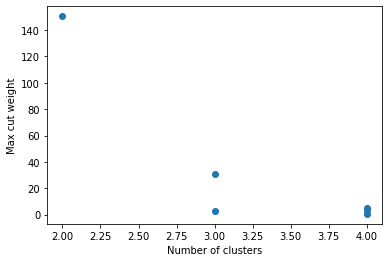

In [8]:
# Plot max-cut weights vs number of clusters created
cuts = []
cluster_num = []

# Get max-cut weights and associated number of clusters from results in df_sub
for i in range(0,h):
    # Collect max-cut weights
    cuts += list(df_sub['cut_'+str(i)].unique())
    # Number how many clusters have been made for this cut
    cut_off = 2**i
    for j in range(0,cut_off):
        cluster_num.append(i+2)

plt.scatter(cluster_num,cuts)
plt.xlabel('Number of clusters')
plt.ylabel('Max cut weight')
plt.show()

Traversing the binary tree along the ‘heaviest’ branches in order stop at the number of leaves associated with the elbow rule. Based on the plot above that would be 3 clusters where the 2nd and 3rd clusters are associated with the point (3,~30)

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

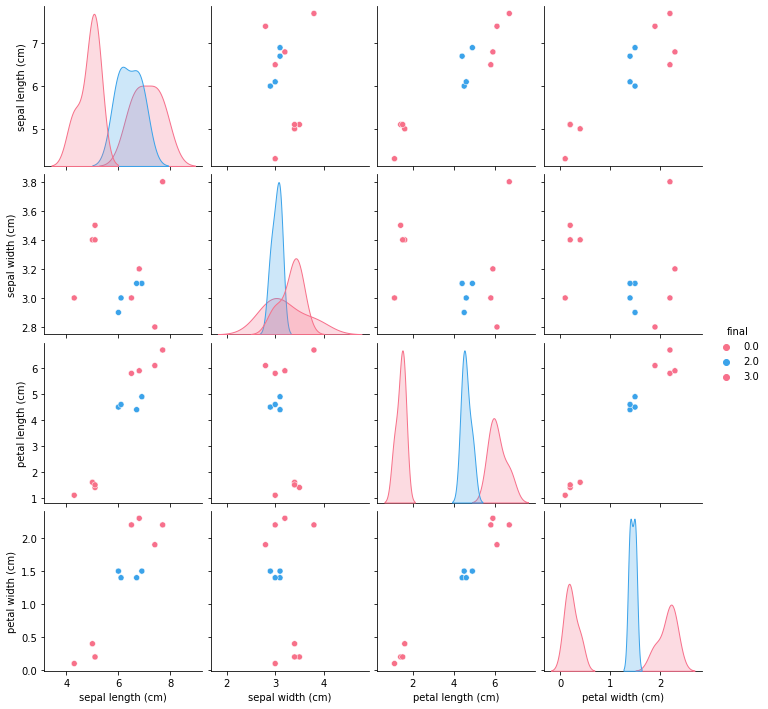

"Average" label classification:
species
setosa        0.0
versicolor    2.0
virginica     3.0
Name: final, dtype: float64


In [9]:
# cut_off sets where the 'elbow' is in for the elbow rule
cut_off = 0.10  # 10% of global maximum is acceptable

# First cut should be the largest compared to subsequent cuts
global_maxim = df_sub['cut_0'].max()

# Initialize final clustering column
df_sub.loc[:,'final'] = np.nan

for (clus_col, cut_col) in zip(df_sub[df_sub.columns[5::2]],df_sub[df_sub.columns[6::2]]):
    # Find the maximum cut for this particular column of data
    maxim = df_sub[cut_col].max()
    if maxim > global_maxim*cut_off:
        df_sub['final'].update(df_sub[clus_col][df_sub[cut_col] == maxim])

# Constrain data to final clustering assignments
df_sub_plot = df_sub[['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)','final']]

# Visualize clustering
sns.pairplot(data=df_sub_plot,hue='final',palette="husl",vars=df_sub.columns[:4])
plt.show()

# Display mean of cluster labels by species
print('\"Average\" label classification:')
print(df_sub.groupby(['species']).sum()['final'] / df_sub.groupby(['species']).count()['final'])

The ‘Average’ label classification is the average cluster label (1, 2, or 3) for each species. Setosa is all in cluster 1; versicolor is all in cluster 2; and virginica is all in cluster 3. The divisive hierarchical quantum clustering performed  a clustering on more than two clusters. Three types of flowers were classified correctly.